# PTML Project

Group :
- paul.messeant
- paul.renoux
- matthieu.schlienger
- nikoloz.chaduneli

### Imports

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# string manipulation libs
import re
import string
import nltk
from nltk.corpus import stopwords

# viz libs
import seaborn as sns


## Part 1 : Supervised learning

*Pick a dataset and perform a supervised learning on it. Ideally, your algorithm
should answer an interesting question about the dataset.*

In [178]:
from get_data import get_data

movies_df, links_df, ratings_df, tags_df, genomesScores_df, genomesTags_df = get_data()

In [179]:
from IPython.display import display

print("Movies")
display(movies_df.tail())
print(movies_df.shape[0])

print("Links")
display(links_df.head())
print(links_df.shape[0])

print("Ratings")
display(ratings_df.head())
print(ratings_df.shape[0])

print("Tags")
display(tags_df.head())
print(tags_df.shape[0])

print("Genome scores")
display(genomesScores_df.head())
print(genomesScores_df.shape[0])

print("Genome tags")
display(genomesTags_df.head())
print(genomesTags_df.shape[0])

Movies


,movieId,title,genres
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)
62422,209171,Women of Devil's Island (1962),Action|Adventure|Drama


62423
Links


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


62423
Ratings


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


25000095
Tags


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


1093360
Genome scores


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


15584448
Genome tags


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


1128


Joining all dataset in a big one

In [180]:
moviesRatings = pd.merge(movies_df, links_df, how='inner', on='movieId')
moviesRatings.drop(["imdbId", "tmdbId"],axis = 1 ,inplace=True)

# Mean of ratings
ratingsMean = ratings_df.groupby("movieId")["rating"].mean()
ratingsMean.rename("Average Rating", inplace=True)

# Most relevant tag
moviesTags = pd.merge(genomesScores_df, genomesTags_df, how='inner', on='tagId')
moviesTags.sort_values(by=['movieId'], axis = 0, inplace = True)
mostRelevantTags = moviesTags.join(
    moviesTags.groupby(['movieId'])
      .relevance.agg(['idxmax']).set_index('idxmax'),
    how='inner'
)
mostRelevantTags = mostRelevantTags[["movieId", "tagId"]]
mostRelevantTags.rename(columns={"movieId" : "movieId", "tagId" : "Most Relevant Tag Id"}, inplace = True)

# Add a number of user ratings

ratingsNb = ratings_df.groupby('movieId').count()
RNb = ratingsNb["rating"]
RNb.rename("Nb of Ratings", inplace=True)

# Add a number of user tags

tagsNb = tags_df.groupby('movieId').count()
TNb = tagsNb["tag"]
TNb.rename("Nb of Tags", inplace=True)

# Most occuring tag amongst users
moviesTags = pd.merge(tags_df, genomesTags_df, how='inner', on='tag')
tagOcc = moviesTags.groupby('movieId')['tagId'].apply(lambda x: x.value_counts().index[0]).reset_index()
tagOcc.rename(columns={"movieId" : "movieId", "tagId" :"Most Common Tag Id"}, inplace=True)
 
# Merge
moviesData = pd.merge(moviesRatings, ratingsMean, how='inner', on='movieId')
moviesData = pd.merge(moviesData, mostRelevantTags, how='inner', on='movieId')
moviesData = pd.merge(moviesData, RNb, how='inner', on='movieId')
moviesData = pd.merge(moviesData, TNb, how='inner', on='movieId')
moviesData = pd.merge(moviesData, tagOcc, how='inner', on='movieId')

moviesData= moviesData[moviesData["Nb of Ratings"] > 50]
moviesData.reset_index(inplace=True, drop=True)
moviesData.drop("title", axis=1, inplace=True)

moviesData.head()

,movieId,genres,Average Rating,Most Relevant Tag Id,Nb of Ratings,Nb of Tags,Most Common Tag Id
0,1,Adventure|Animation|Children|Comedy|Fantasy,3.893708,1036,57309,697,64
1,2,Adventure|Children|Fantasy,3.251527,29,24228,180,377
2,3,Comedy|Romance,3.142028,901,11804,29,901
3,4,Comedy|Drama|Romance,2.853547,1116,2523,11,201
4,5,Comedy,3.058434,901,11714,24,374


In [181]:
# Lets just check how often the most relevant tag is the same as the most occuring one

moviesData["isSameTag"] = np.where(moviesData['Most Relevant Tag Id'] == moviesData['Most Common Tag Id'] , True, False)
same = moviesData["isSameTag"].sum()
print("The most common tag is the same as the most relevant one on", same, "movies out of", moviesData.shape[0], "movies. This is a proportion of", round((same/moviesData.shape[0])*100), "%.")
moviesData.drop("isSameTag", axis=1, inplace=True)


The most common tag is the same as the most relevant one on 2666 movies out of 12108 movies. This is a proportion of 22 %.


#### Seing this, we can assume that the most common tag might also be relevant to train our model, since it differs a lot from the most relevant tag. 

#### We also consider that the number of rating might matter, as the more people rate a movie, the less likely it is to have a high rating.

#### Number of tags might be relevant, as we could think that the fewer tags there are, the less relevant to the final rating they should be.


## Analysis

In [182]:
moviesData.describe()

,movieId,Average Rating,Most Relevant Tag Id,Nb of Ratings,Nb of Tags,Most Common Tag Id
count,12108.000000,12108.000000,12108.000000,12108.000000,12108.000000,12108.000000
mean,45439.678312,3.295298,578.692022,2015.907417,76.555005,564.560456
std,54617.526347,0.480202,328.123479,5170.753352,197.841276,331.683345
min,1.000000,0.899038,1.000000,51.000000,1.000000,1.000000
25%,3807.750000,3.016632,288.000000,126.000000,13.000000,280.000000
50%,8530.500000,3.367210,587.000000,371.000000,25.000000,588.000000
75%,79077.500000,3.651551,865.000000,1432.000000,60.000000,855.000000
max,206499.000000,4.483096,1128.000000,81491.000000,6180.000000,1128.000000


##### We can see here that we only kept the movies that had at least one rating and one tag, as intended. So no minimum is ever at 0 for those 2 columns.

#### We are now trying to find any outliers

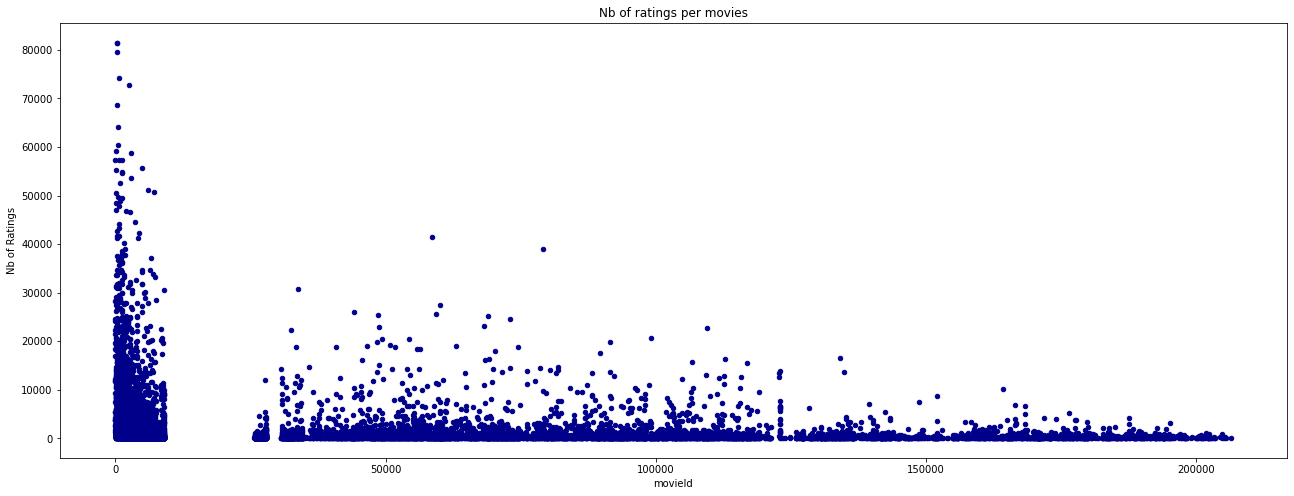

In [183]:
ax = moviesData.plot.scatter(x='movieId', y = "Nb of Ratings", c="DarkBlue", figsize=(22,8), title="Nb of ratings per movies")

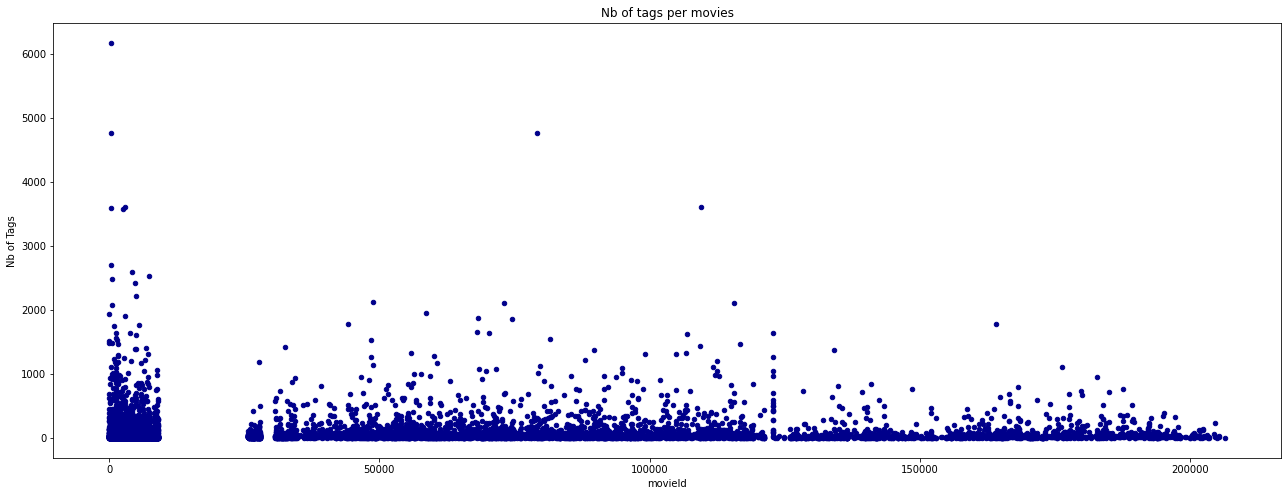

In [184]:
ax = moviesData.plot.scatter(x='movieId', y = "Nb of Tags", c="DarkBlue", figsize=(22,8), title="Nb of tags per movies")

##### We can see there are a few outliers, that would be movies with too many ratings or too many tags. We will remove those outliers in order to have a better training set.
##### There are some IDs with nothing, that is because some IDs aren't associated with any movie.

In [185]:
# Remove extreme values

moviesData = moviesData[(moviesData['Nb of Tags'] <= 3000) & (moviesData['Nb of Ratings'] <= 40000)]
moviesData.reset_index(inplace=True, drop=True)

##### Now let's see the correlation between the different values

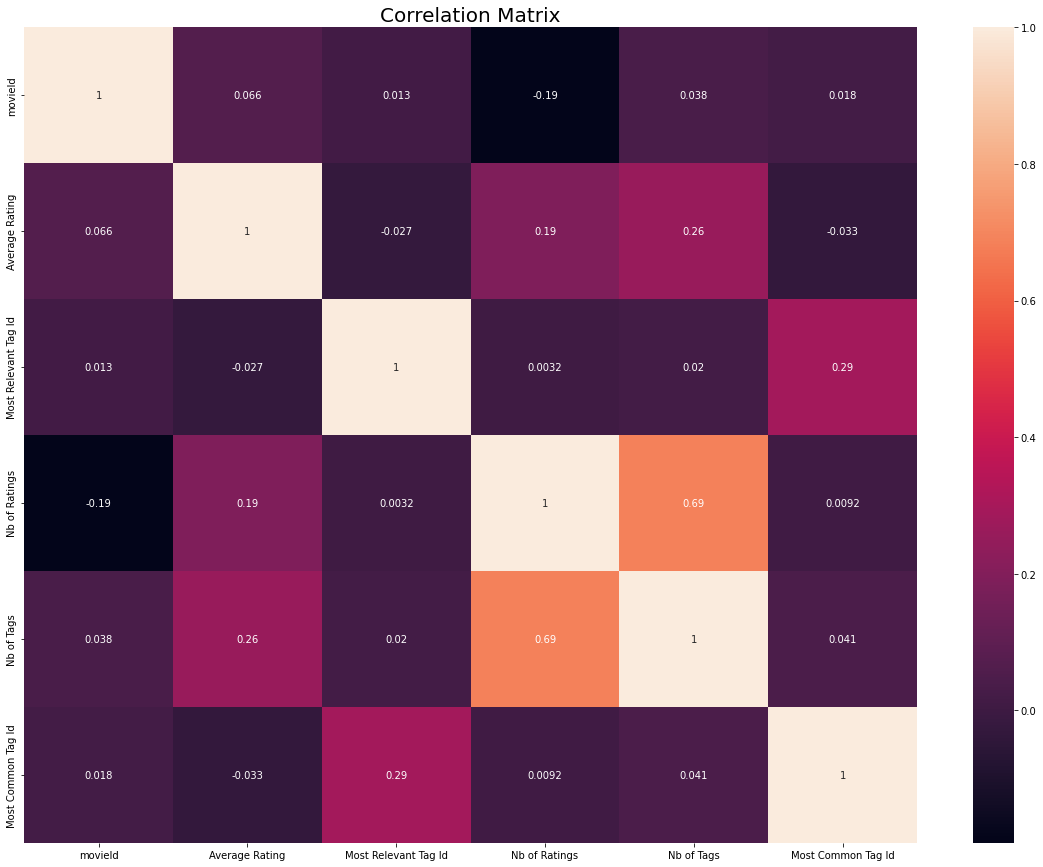

In [186]:
plt.figure(figsize=(20,15))
sns.heatmap(moviesData.corr(), annot = True) #overall correlation between the various columns present in our data
plt.title('Correlation Matrix', fontsize = 20)
plt.show()

##### The number of ratings and the number of tags do have some impact on the rating, even if it isnt very highly correlated. But it seems like the most relevant tag and the most common tag associated with the movie have almost no correlation with its rating.

### For the purpose of analysis, we take a look at the most occuring tags, both as the most relevant one and as the most commonly given by users.

In [187]:
common = moviesData["Most Common Tag Id"].mode()
relevant = moviesData["Most Relevant Tag Id"].mode()

commonTag = genomesTags_df.loc[genomesTags_df['tagId'] == common.values[0]]["tag"]

relevantTag = genomesTags_df.loc[genomesTags_df['tagId'] == relevant.values[0]]["tag"]

print("The most common tag associated at movies given by users: `%s`" % commonTag.tolist()[0])
print("The most common of the most relevant tags associated to the movies: `%s` " % relevantTag.tolist()[0])

The most common tag associated at movies given by users: `based on a book`
The most common of the most relevant tags associated to the movies: `criterion` 


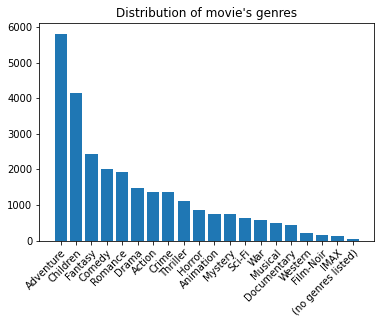

In [188]:
genres = pd.Series(moviesData[["movieId", "genres"]]["genres"].str.split("|", expand=False).sum())
genresCount = genres.value_counts()

abs = np.arange(len(genres.unique()))
ord = genresCount.values

plt.bar(abs, ord)
ax = plt.gca()
plt.draw()
ax.set_xticks(abs)
ax.set_xticklabels(genres.unique(), rotation = 45, ha='right', rotation_mode='anchor')
plt.title("Distribution of movie's genres")
plt.show()

We can see that the most represented movie genres are adventure and animation films 

In [189]:
possibleGenres = pd.Series(moviesData[["movieId", "genres"]]["genres"].str.split("|", expand=False).sum()).unique()

In [190]:
X = moviesData
display(X)

y = moviesData["Average Rating"]

encoder = np.zeros((len(X["genres"]),len(possibleGenres)))
print(X["genres"])

eo = {g : i for g,i in zip(possibleGenres, list(range(0,len(possibleGenres))))}

for i in range(len(encoder)):
    gen = X["genres"][i].split('|')
    for genre in gen:
        encoder[i][eo[genre]]+=1
        
print(encoder)
toMerge = pd.DataFrame(encoder, columns=possibleGenres)

X = X.merge(toMerge, left_index=True, right_index=True)

X.drop([
    "movieId", "Most Relevant Tag Id", "Most Common Tag Id", "genres", "Average Rating"
    ], axis=1, inplace=True)

display(X.head())


,movieId,genres,Average Rating,Most Relevant Tag Id,Nb of Ratings,Nb of Tags,Most Common Tag Id
0,2,Adventure|Children|Fantasy,3.251527,29,24228,180,377
1,3,Comedy|Romance,3.142028,901,11804,29,901
2,4,Comedy|Drama|Romance,2.853547,1116,2523,11,201
3,5,Comedy,3.058434,901,11714,24,374
4,6,Action|Crime|Thriller,3.854909,268,24588,621,841
...,...,...,...,...,...,...,...
12060,204704,Comedy|Horror|Thriller,3.425926,374,54,23,522
12061,205072,Action|Comedy|Horror,3.310345,333,58,8,19
12062,205383,Crime|Drama|Thriller,3.642857,742,252,26,212
12063,205425,Comedy,3.543478,963,69,11,963


0        Adventure|Children|Fantasy
1                    Comedy|Romance
2              Comedy|Drama|Romance
3                            Comedy
4             Action|Crime|Thriller
                    ...            
12060        Comedy|Horror|Thriller
12061          Action|Comedy|Horror
12062          Crime|Drama|Thriller
12063                        Comedy
12064                        Comedy
Name: genres, Length: 12065, dtype: object
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


,Nb of Ratings,Nb of Tags,Adventure,Children,Fantasy,Comedy,Romance,Drama,Action,Crime,...,Animation,Mystery,Sci-Fi,War,Musical,Documentary,Western,Film-Noir,IMAX,(no genres listed)
0,24228,180,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11804,29,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2523,11,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11714,24,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24588,621,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Nb of Ratings,Nb of Tags,Adventure,Children,Fantasy,Comedy,Romance,Drama,Action,Crime,...,Animation,Mystery,Sci-Fi,War,Musical,Documentary,Western,Film-Noir,IMAX,(no genres listed)
1374,460,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3118,237,14,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11340,145,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3780,126,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10933,226,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Mean squared error: 0.16
Coefficient of determination: 0.29


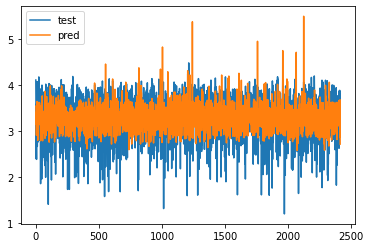

R2 cross validation: [0.35051542 0.2598816  0.21152448 0.27413734 0.16896853]
Mean absolute error cross validation: [-0.33588969 -0.3483971  -0.32023974 -0.28444236 -0.29338086]


In [191]:
from sklearn.metrics import  SCORERS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train.head())

y_train = y_train.ravel()
y_test = y_test.ravel()

reg = LinearRegression().fit(X_train,y_train)

y_pred = reg.predict(X_test)

# The mean squared error
y_pred=y_pred.ravel()
y_test = y_test.ravel()
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

scoring = {'mse': 'neg_mean_absolute_error',
           'r2': 'r2'}

plt.plot(np.arange(len(y_test)), y_test,label='test')
plt.plot(np.arange(len(y_pred)), y_pred,label='pred')
plt.legend()
plt.show()

scores = cross_validate(reg, X, y, cv=5, scoring=scoring)
print(f"R2 cross validation: {scores['test_r2']}")
print(f"Mean absolute error cross validation: {scores['test_mse']}")